In [1]:
"""!pip install "../input/pretrained-models/pretrained-models/pretrained-models.pytorch-master"""

'!pip install "../input/pretrained-models/pretrained-models/pretrained-models.pytorch-master'

In [2]:
import sys
package_path = "../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master"
sys.path.append(package_path)

In [3]:
import os
os.listdir("../input/efficientnet-pytorch/efficientnet-pytorch/EfficientNet-PyTorch-master")

['.gitignore',
 'tf_to_pytorch',
 'examples',
 'LICENSE',
 'efficientnet_pytorch',
 'README.md',
 'setup.py']

In [4]:
# libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import time 
import tqdm
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import copy
import cv2
import albumentations
from albumentations import torch as AT
import random


#import pretrainedmodels
from efficientnet_pytorch import EfficientNet

## Data overview

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
seed_everything(1234)

In [7]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
sample_submission = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels_cropped.csv')




In [8]:
old_train = old_train[['image','level']]
old_train.columns = train.columns
old_train.diagnosis.value_counts()

0    25802
2     5288
1     2438
3      872
4      708
Name: diagnosis, dtype: int64

In [9]:
"""# path columns
train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/' + old_train['id_code'].astype(str) + '.jpeg'"""

"# path columns\ntrain['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + train['id_code'].astype(str) + '.png'\nold_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/' + old_train['id_code'].astype(str) + '.jpeg'"

In [10]:
"""train = pd.concat([train, old_train], ignore_index=True)"""

'train = pd.concat([train, old_train], ignore_index=True)'

In [11]:
"""train_images = [i for i in train['id_code'].values]
image_test = train_images[4000]
image_test"""

"train_images = [i for i in train['id_code'].values]\nimage_test = train_images[4000]\nimage_test"

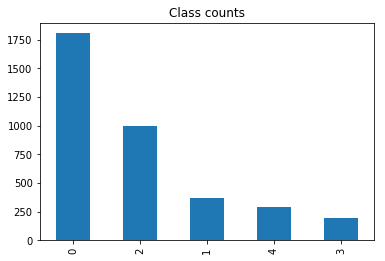

In [12]:
train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Class counts');

## Data preparation

In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def prepare_labels(y):
    # From here: https://www.kaggle.com/pestipeti/keras-cnn-starter
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    y = onehot_encoded
    return y, label_encoder

In [14]:
y, le = prepare_labels(train['diagnosis'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [15]:
y_old, le_old = prepare_labels(old_train['diagnosis'])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
class GlassDataset(Dataset):
    def __init__(self, df, datatype, transform, y = None):
        self.df = df
        self.datatype = datatype
        if self.datatype == 'val':
            # self.image_files_list = [i for i in df['id_code'].values]
            self.image_files_list = [f'../input/aptos2019-blindness-detection/train_images/{i}.png' for i in df['id_code'].values]
            self.labels = y
        elif self.datatype == 'train':
            # self.image_files_list = [i for i in df['id_code'].values]
            self.image_files_list = [f'../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/{i}.jpeg' for i in df['id_code'].values]
            self.labels = y
        else:
            self.image_files_list = [f'../input/aptos2019-blindness-detection/{self.datatype}_images/{i}.png' for i in df['id_code'].values]
            self.labels = np.zeros((df.shape[0], 5))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img = cv2.imread(img_name)
        image = self.transform(image=img)
        image = image['image']

        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels[idx]
        if self.datatype == 'test':
            return image, label, img_name
        else:
            return image, label

In [17]:
img_size = 256

data_transforms = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightness(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(img_size, img_size),
    albumentations.Normalize(),
    albumentations.HorizontalFlip(),
    albumentations.RandomRotate90(),
    AT.ToTensor()
    ])


dataset = GlassDataset(df=old_train, datatype='train', transform=data_transforms, y=y_old)
test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)
batch_size = 16
num_workers = 0
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,  num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


In [18]:
val_dataset = GlassDataset(df=train, datatype='val', transform=data_transforms, y=y)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,  num_workers=num_workers)

In [19]:
#test_set = GlassDataset(df=test, datatype='test', transform=data_transforms_test)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)



In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
import os
os.listdir("../input/se-resnext-pytorch-pretrained")

['se_resnext50_32x4d-a260b3a4.pth', 'se_resnext101_32x4d-3b2fe3d8.pth']

In [22]:
model_conv = EfficientNet.from_name('efficientnet-b4')
model_conv.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth'))
for param in model_conv.parameters():
    param.requires_grad = False
in_features = model_conv._fc.in_features
model_conv._fc = nn.Linear(in_features, 5)
model_conv.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [23]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, n_epochs=15, attempt=1):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # current number of epochs, where validation loss didn't increase
    p = 0
    # whether training should be stopped
    stop = False

    # number of epochs to train the model
    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []
        train_auc = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target.float())
            train_loss.append(loss.item())

            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            # train_auc.append(roc_auc_score(a, b))
            loss.backward()
            optimizer.step()

        model_conv.eval()
        val_loss = []
        val_auc = []
        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model_conv(data)

            loss = criterion(output, target.float())

            val_loss.append(loss.item()) 
            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            # val_auc.append(roc_auc_score(a, b))

        # print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, train auc: {np.mean(train_auc):.4f}, valid auc: {np.mean(val_auc):.4f}')
        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}.')

        valid_loss = np.mean(val_loss)
        scheduler.step(valid_loss)
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_conv.state_dict(), 'model_{}.pt'.format(attempt))
            valid_loss_min = valid_loss
            p = 0

        # check if validation loss didn't improve
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv

In [24]:

criterion = nn.MSELoss()
optimizer = optim.SGD(model_conv.parameters(), lr=0.0005, momentum=0.99)
#scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, )

## Model training

In [25]:
model_resnet101 = train_model(model_conv, train_loader, valid_loader, criterion = criterion, 
                              optimizer = optimizer, n_epochs=5, attempt=1)

Sat Sep  7 12:43:54 2019 Epoch: 1
Epoch 1, train loss: 0.0977, valid loss: 0.1404.
Validation loss decreased (inf --> 0.140388).  Saving model ...
Sat Sep  7 13:01:15 2019 Epoch: 2
Epoch 2, train loss: 0.0841, valid loss: 0.1240.
Validation loss decreased (0.140388 --> 0.124009).  Saving model ...
Sat Sep  7 13:18:55 2019 Epoch: 3
Epoch 3, train loss: 0.0833, valid loss: 0.1189.
Validation loss decreased (0.124009 --> 0.118861).  Saving model ...
Sat Sep  7 13:36:21 2019 Epoch: 4
Epoch 4, train loss: 0.0832, valid loss: 0.1271.
1 epochs of increasing val loss
Sat Sep  7 13:53:31 2019 Epoch: 5
Epoch 5, train loss: 0.0828, valid loss: 0.1258.
2 epochs of increasing val loss
